# Prediction Model with Facebook Prophet
Prophet is designed for analyzing time series with daily observations that display patterns on different time scales. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. It also has advanced capabilities for modeling the effects of holidays on a time-series 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet_model import *
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [2]:
df = pd.read_csv('../../data/dataset.csv')
df.index = pd.to_datetime(df.pop('date'))
df = df.asfreq('D')
df = df.filter(['date', 'Canteen'])
df.fillna(method="ffill", inplace=True)

Text(0.5, 1.0, 'Number of people at Telenor 2016-2019')

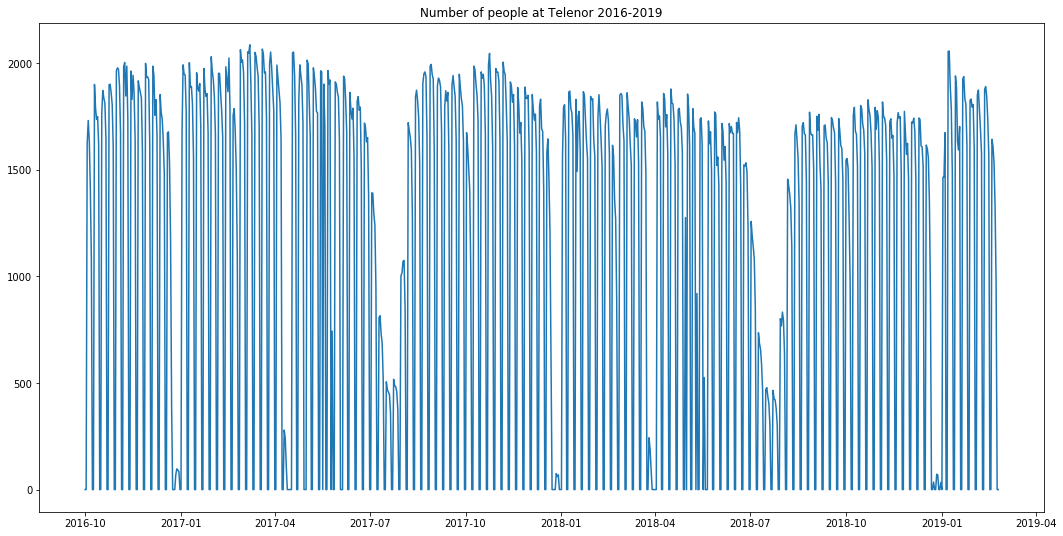

In [3]:
plt.figure(figsize=(18,9))
plt.plot(df)
plt.title('Number of people at Telenor 2016-2019')

#### Business days only 

In [ ]:
business = df.resample('B').sum()

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(business)
plt.title('Number of people on business days')

In [ ]:
business_log = business.copy()
business_log['Canteen'] = np.log(business_log['Canteen']) 

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(business_log)
plt.title('Log(Number of people on business days)')

In [ ]:
business.reset_index(inplace=True)
business = business.rename(columns={'date': 'ds', 'Canteen': 'y'})

#### Resetting index and renaming columns

In [4]:
df = preprocess_dataframe(df)

In [5]:
df.head()

,ds,y
0,2016-10-01,0.0
1,2016-10-02,0.0
2,2016-10-03,1622.0
3,2016-10-04,1730.0
4,2016-10-05,1635.0


## Prediction
#### Split into training and test data 

In [6]:
test_period = 8 # days we are predicting in the future

train = df.iloc[:-test_period]
test = df.iloc[-test_period:]

#### Prophet prediction model

In [7]:
forecast, model = prophet_prediction(train, test)

/usr/local/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [8]:
get_readable_forecast_info(forecast).head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-10-01,-46.822120,-498.463836,370.475440
1,2016-10-02,-45.141444,-449.582755,377.781915
2,2016-10-03,1703.984401,1277.747151,2120.825083
3,2016-10-04,1730.890290,1300.335064,2137.517260
4,2016-10-05,1684.808803,1273.714553,2107.386483


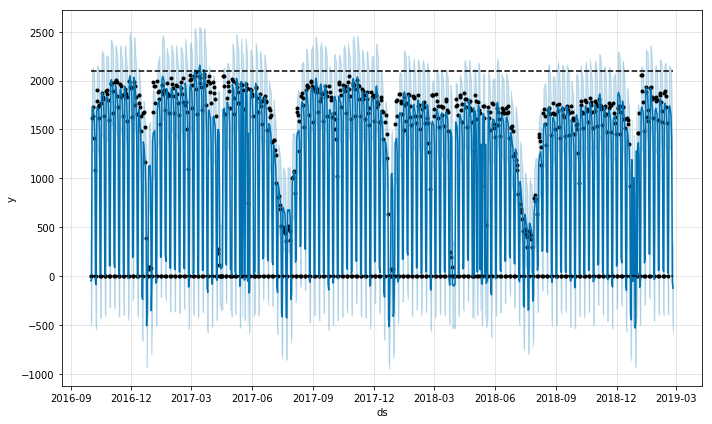

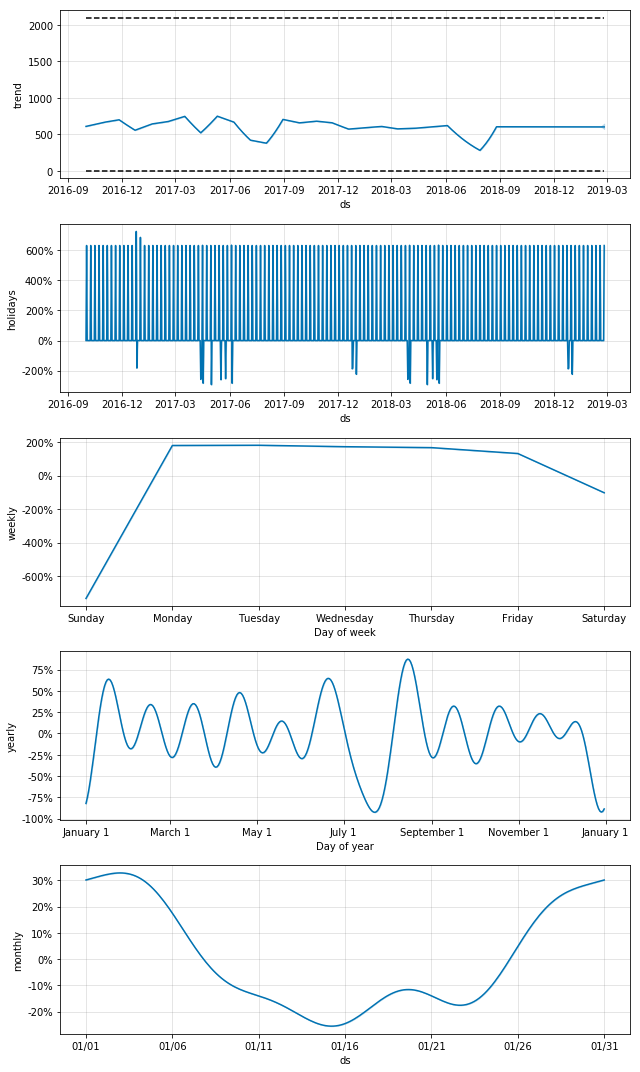

In [9]:
plot_forecast_and_components(model, forecast)

### Evaluation

In [10]:
df_cv, df_p = evaluate_model(model)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-11-08 00:00:00 and 2019-02-08 00:00:00
/usr/local/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/usr/local/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Skipping MAPE because y close to 0


In [11]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-11-09,1439.042901,981.099563,1893.937766,1547.0,2018-11-08
1,2018-11-10,-39.314197,-468.438639,400.604538,0.0,2018-11-08
2,2018-11-11,-50.753052,-443.871715,378.057096,0.0,2018-11-08
3,2018-11-12,1742.672491,1312.697738,2161.457641,1723.0,2018-11-08
4,2018-11-13,1745.166163,1316.832669,2199.592240,1738.0,2018-11-08


In [12]:
df_p

,horizon,mse,rmse,mae,coverage
0,1 days,7002.129444,83.678728,78.214492,1.0
1,2 days,1086.737018,32.965695,32.185745,1.0
2,3 days,13058.398530,114.273350,102.091786,1.0
3,4 days,11802.910167,108.641199,86.024849,1.0
4,5 days,11659.541970,107.979359,79.851899,1.0
5,6 days,4016.307476,63.374344,61.086059,1.0
6,7 days,8843.503463,94.039904,73.088830,1.0
7,8 days,3136.526777,56.004703,46.770496,1.0


In [13]:
df_p['mae'].mean()

69.91426965783673

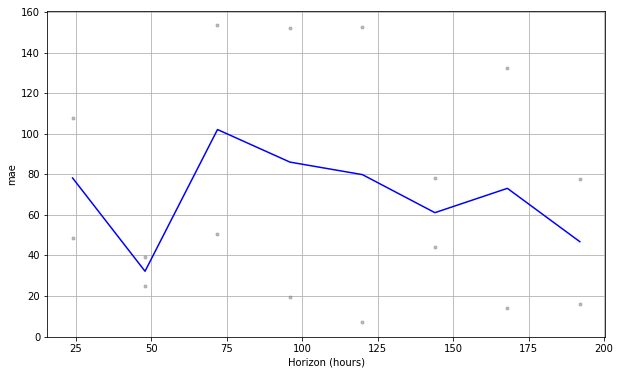

In [14]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

### More evaluation

In [15]:
comparison = forecast.filter(['ds', 'yhat'])
comparison['true'] = test['y']
comp = comparison.dropna()
comp.index = pd.to_datetime(comp.pop('ds'))

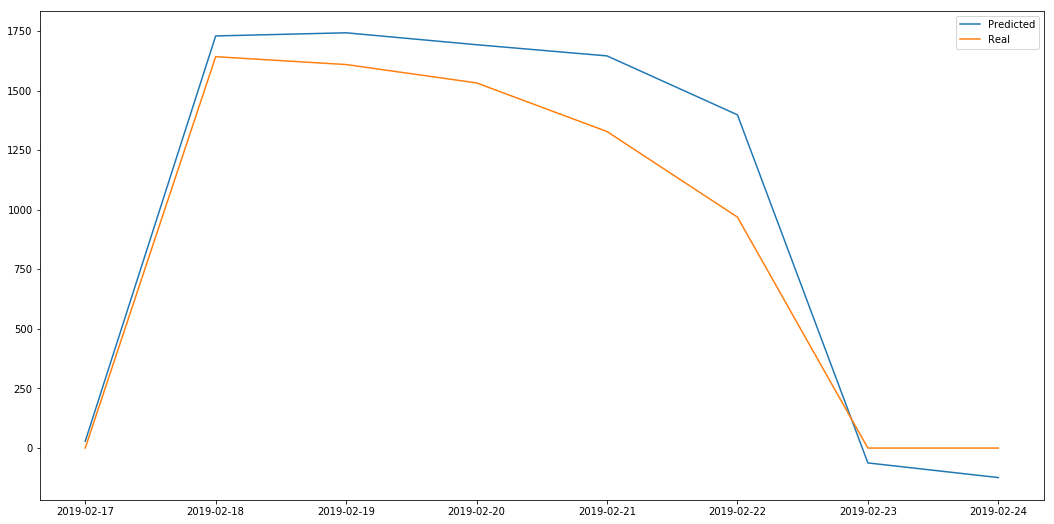

In [16]:
plt.figure(figsize=(18,9))
plt.plot(comp)
plt.legend(['Predicted', 'Real'])